In [ ]:
# https://www.openml.org/search?type=data&id=44096&sort=runs&status=active

In [189]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2, chi2_contingency, ttest_ind

plt.rcParams['figure.figsize'] = [10, 5]

In [190]:
arff_file = arff.loadarff('./dataset_31_credit-g.arff')
df = pd.DataFrame(arff_file[0])

df.head()

,checking_status,duration,credit_history,purpose,credit_amount,...,job,num_dependents,own_telephone,foreign_worker,class
0,b'<0',6.0,b'critical/other existing credit',b'radio/tv',1169.0,...,b'skilled',1.0,b'yes',b'yes',b'good'
1,b'0<=X<200',48.0,b'existing paid',b'radio/tv',5951.0,...,b'skilled',1.0,b'none',b'yes',b'bad'
2,b'no checking',12.0,b'critical/other existing credit',b'education',2096.0,...,b'unskilled resident',2.0,b'none',b'yes',b'good'
3,b'<0',42.0,b'existing paid',b'furniture/equipment',7882.0,...,b'skilled',2.0,b'none',b'yes',b'good'
4,b'<0',24.0,b'delayed previously',b'new car',4870.0,...,b'skilled',2.0,b'none',b'yes',b'bad'


In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [192]:
for col in df.select_dtypes(include="object").columns:
    print("{:<20} {}".format(col, ", ".join(map(lambda b: b.decode("utf-8"), list(df[col].unique())))))

checking_status      <0, 0<=X<200, no checking, >=200
credit_history       critical/other existing credit, existing paid, delayed previously, no credits/all paid, all paid
purpose              radio/tv, education, furniture/equipment, new car, used car, business, domestic appliance, repairs, other, retraining
savings_status       no known savings, <100, 500<=X<1000, >=1000, 100<=X<500
employment           >=7, 1<=X<4, 4<=X<7, unemployed, <1
personal_status      male single, female div/dep/mar, male div/sep, male mar/wid
other_parties        none, guarantor, co applicant
property_magnitude   real estate, life insurance, no known property, car
other_payment_plans  none, bank, stores
housing              own, for free, rent
job                  skilled, unskilled resident, high qualif/self emp/mgmt, unemp/unskilled non res
own_telephone        yes, none
foreign_worker       yes, no
class                good, bad


In [193]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


<Axes: >

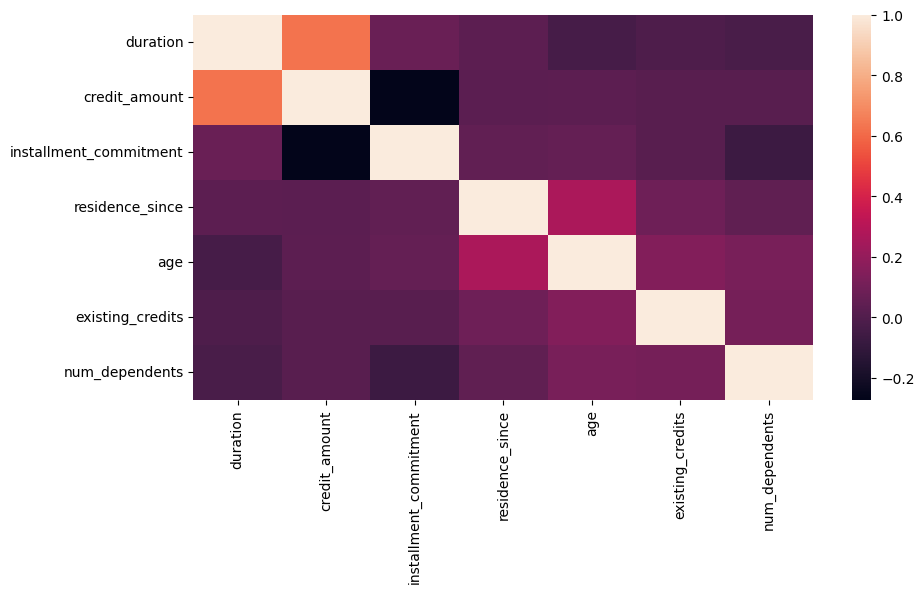

In [194]:
sns.heatmap(df.corr(numeric_only=True))

In [195]:
# Credit amount and duration are highly correlated with coef of ~0.8. That makes sense as the size of the loan grows,
# the duration typically grows as well.

# Let's combine these into a single "monthly payment amount" feature
df['monthly_payment_amount'] = df['credit_amount'] / df['duration']

# I don't want to just remove `duration` because I have a suspicion that shorter term loans (i.e. layaway or payday loans)
# should be treated differently than long term loans (such as for a car).

# https://corporatefinanceinstitute.com/resources/accounting/short-term-loan/ seems to indicate that anything under
# 18 months is considered a short term loan and anything over is long term. Let's create a "is_short_term" feature

df['is_short_term'] = pd.cut(df['duration'], bins=[0, 18, 999], labels=['yes', 'no'])

# df.drop(['credit_amount', 'duration'], axis=1, inplace=True)

In [196]:
# Make sure we didn't add any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   object  
 1   duration                1000 non-null   float64 
 2   credit_history          1000 non-null   object  
 3   purpose                 1000 non-null   object  
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   object  
 6   employment              1000 non-null   object  
 7   installment_commitment  1000 non-null   float64 
 8   personal_status         1000 non-null   object  
 9   other_parties           1000 non-null   object  
 10  residence_since         1000 non-null   float64 
 11  property_magnitude      1000 non-null   object  
 12  age                     1000 non-null   float64 
 13  other_payment_plans     1000 non-null   object  
 14  housing                 1

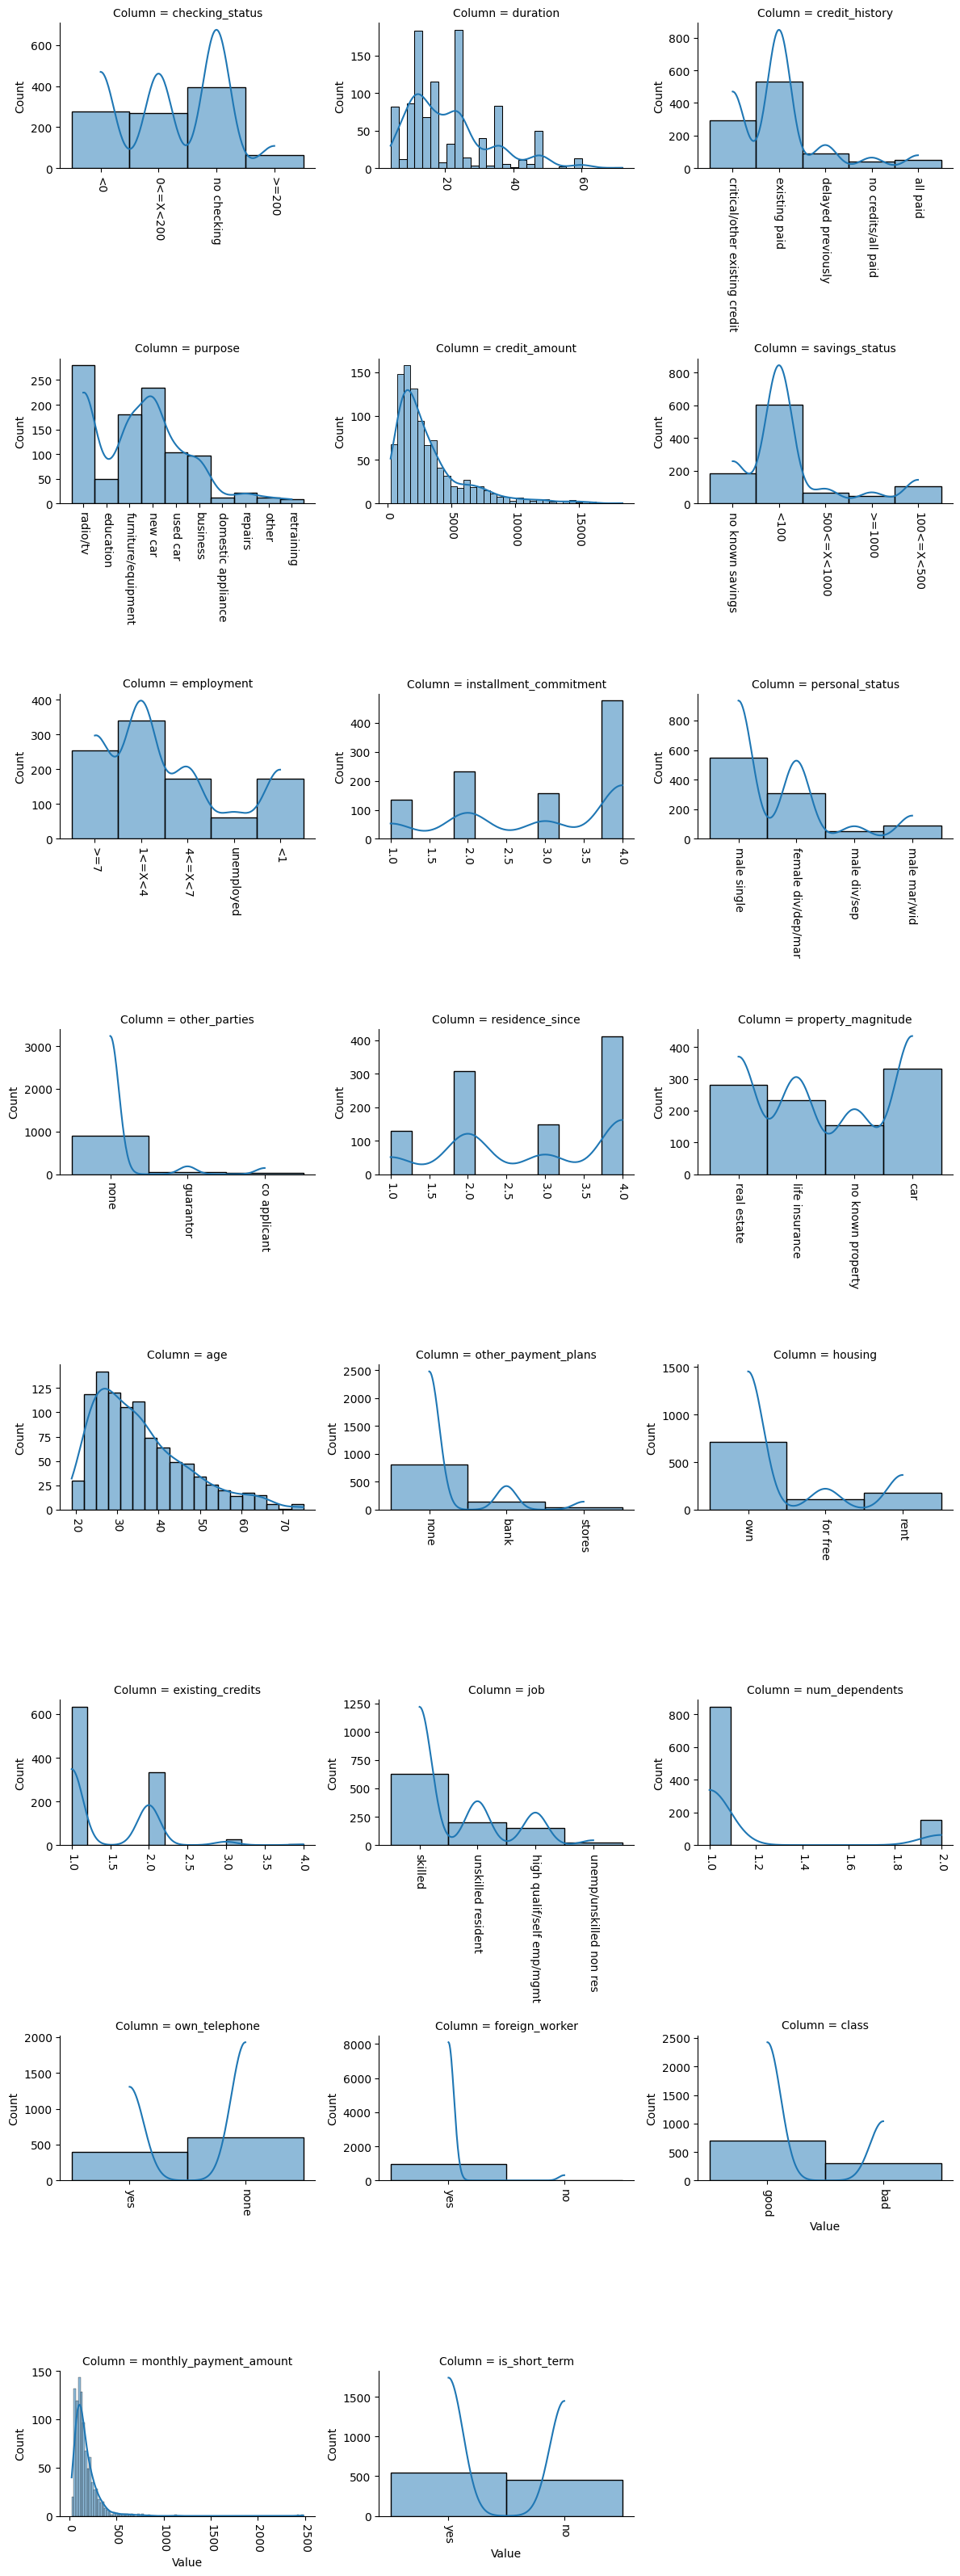

In [197]:
data_melted = df[df.columns].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(data_melted, col='Column', col_wrap=3, sharex=False, sharey=False, height=4)

g.tick_params(axis='x', rotation=-90)
g.map(sns.histplot, 'Value', kde=True)

plt.show()

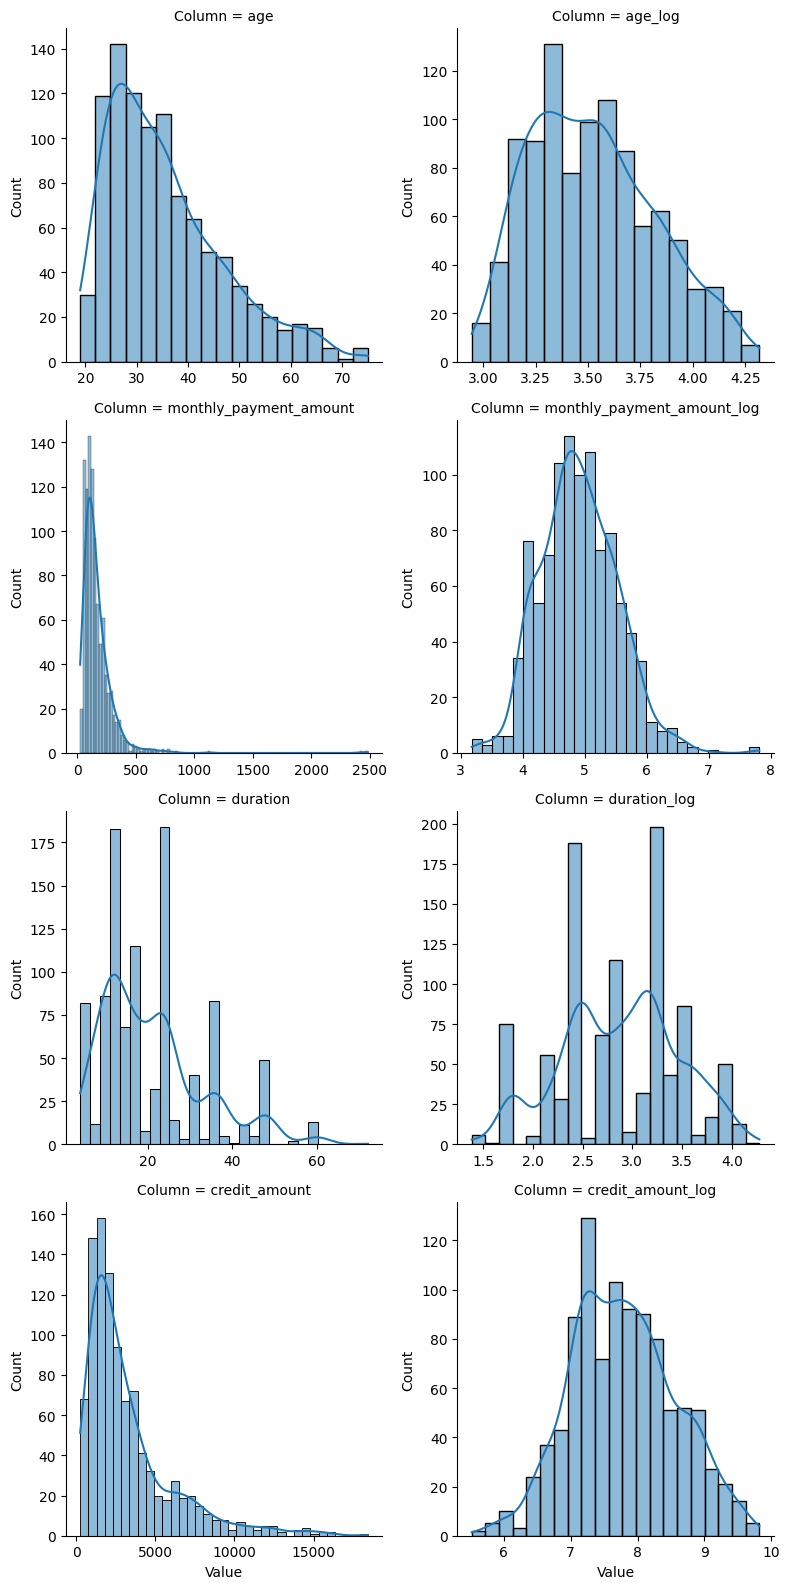

In [209]:
# Numeric features are skewed and could benefit from normalization.

df['age_log'] = np.log(df['age'])
df['monthly_payment_amount_log'] = np.log(df['monthly_payment_amount'])
df['duration_log'] = np.log(df['duration'])
df['credit_amount_log'] = np.log(df['credit_amount'])


data_melted = df[[
    'age',
    'age_log',
    'monthly_payment_amount',
    'monthly_payment_amount_log',
    'duration',
    'duration_log',
    'credit_amount',
    'credit_amount_log'
]].melt(var_name='Column', value_name='Value')

g = sns.FacetGrid(data_melted, col='Column', col_wrap=2, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', kde=True)

In [210]:
ordinal_columns = [
    "checking_status",
    "savings_status",
    "employment",

    # These could be either numeric or ordinal, we'll keep them ordinal since they have a low DOF
    "installment_commitment",
    "residence_since",
    "existing_credits",
    "num_dependents",
]

nominal_columns = [
    "credit_history",
    "purpose",
    "personal_status",
    "other_parties",
    "property_magnitude",
    "other_payment_plans",
    "housing",
    "job",
    "own_telephone",
    "foreign_worker",
    "is_short_term",
]

numeric_columns = [
    "age_log",
    "monthly_payment_amount_log"
]

In [211]:
def chi_square_test(data, cat_feature):
    contingency_table = pd.crosstab(data[cat_feature], data['class'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p, dof

cst_results = {
    'feature': [],
    'chi2': [],
    'p': [],
    'dof': [],
}

for feature in ordinal_columns + nominal_columns:
    chi2, p, dof = chi_square_test(df, feature)

    cst_results['feature'].append(feature)
    cst_results['chi2'].append(chi2)
    cst_results['p'].append(p)
    cst_results['dof'].append(dof)

pd.DataFrame(cst_results).sort_values(by='p')

,feature,chi2,p,dof
0,checking_status,123.720944,1.218902e-26,3
7,credit_history,61.691397,1.279187e-12,4
1,savings_status,36.098928,2.761214e-07,4
17,is_short_term,18.820055,1.436487e-05,1
11,property_magnitude,23.719551,2.858442e-05,3
13,housing,18.199842,1.116747e-04,2
8,purpose,33.356447,1.157491e-04,9
2,employment,18.368274,1.045452e-03,4
12,other_payment_plans,12.839188,1.629318e-03,2
16,foreign_worker,5.821576,1.583075e-02,1


In [214]:
def t_test(data, num_feature):
    good_credit = data[data['class'] == b'good'][num_feature]
    bad_credit = data[data['class'] == b'bad'][num_feature]
    t_stat, p = ttest_ind(good_credit, bad_credit, equal_var=False)

    return t_stat, p

tt_results = {
    'feature': [],
    't_stat': [],
    'p': [],
}

for feature in numeric_columns:
    t_stat, p = t_test(df, feature)

    tt_results['feature'].append(feature)
    tt_results['t_stat'].append(t_stat)
    tt_results['p'].append(p)

pd.DataFrame(tt_results).sort_values(by='p')

,feature,t_stat,p
0,age_log,3.238357,0.001274
1,monthly_payment_amount_log,1.932800,0.053833


<Axes: xlabel='age_bin', ylabel='Count'>

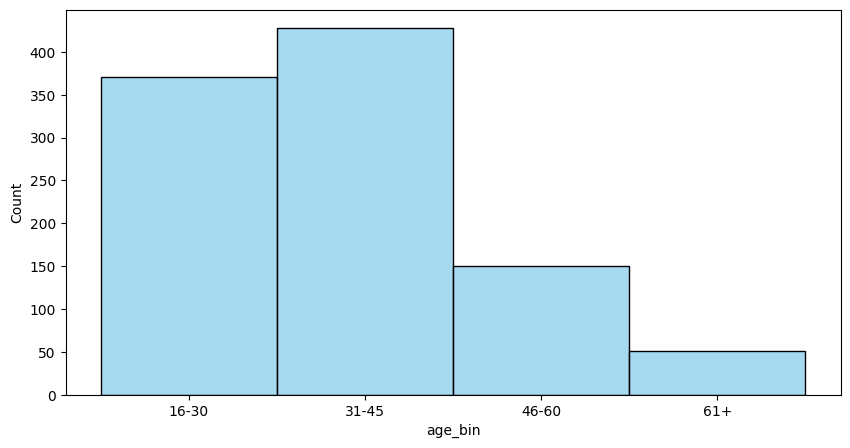

In [229]:
df['age_bin'] = pd.cut(df['age'], bins=[0, 15, 30, 45, 60, 999], labels=['0-15', '16-30', '31-45', '46-60', '61+'], right=False)
sns.histplot(data=df, x='age_bin', stat='count', color='skyblue', kde=False)

In [232]:
chi2, p, dof = chi_square_test(df, 'age_bin')
print(f'chi2 = {chi2}')
print(f'p value = {p}')

chi2 = 13.641908582630133
p value = 0.0034354067021998462
